In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rzdjafari","key":"0d8b1ff50c65e205d19f937b3d60f4f7"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                     Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           8899        276  1.0              
devansodariya/student-performance-data                       Student Performance Dataset                           7KB  2022-05-26 13:55:09           4583        151  0.9705882        
iamsouravbanerjee/software-professional-salaries-2022        Salary Dataset - 2022                               526KB  2022-06-15 17:13:05           1699         45  1.0              
paradisejoy/top-hits-spotify-from-20002019                   Top Hits Spoti

In [9]:
!kaggle competitions download -c severstal-steel-defect-detection

severstal-steel-defect-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip /content/severstal-steel-defect-detection.zip -d /content/drive

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/train_images/99f75320d.jpg  
  inflating: /content/drive/train_images/99f9d2375.jpg  
  inflating: /content/drive/train_images/99fd3c6f5.jpg  
  inflating: /content/drive/train_images/9a016fe15.jpg  
  inflating: /content/drive/train_images/9a064450d.jpg  
  inflating: /content/drive/train_images/9a08c2783.jpg  
  inflating: /content/drive/train_images/9a18e4457.jpg  
  inflating: /content/drive/train_images/9a1f7c238.jpg  
  inflating: /content/drive/train_images/9a2523ce9.jpg  
  inflating: /content/drive/train_images/9a3e774ff.jpg  
  inflating: /content/drive/train_images/9a5e9e77c.jpg  
  inflating: /content/drive/train_images/9a5f7a855.jpg  
  inflating: /content/drive/train_images/9a62177bb.jpg  
  inflating: /content/drive/train_images/9a67575cf.jpg  
  inflating: /content/drive/train_images/9a6ac5406.jpg  
  inflating: /content/drive/train_images/9a70057c0.jpg  
  inflating: /content/drive/train_ima

In [11]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [12]:
train_df_origin = pd.read_csv('/content/drive/train.csv')
train_df_origin.shape

(7095, 3)

In [13]:
train_df_origin

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [14]:
TRAIN_PATH = '/content/drive/train_images/'
from glob import glob
train_fns = pd.Series(sorted(glob(TRAIN_PATH + '*.jpg')))
train_fns_split = train_fns.str.split('/', expand=True)

In [15]:
train_fns_split

,0,1,2,3,4
0,,content,drive,train_images,0002cc93b.jpg
1,,content,drive,train_images,00031f466.jpg
2,,content,drive,train_images,000418bfc.jpg
3,,content,drive,train_images,000789191.jpg
4,,content,drive,train_images,0007a71bf.jpg
...,...,...,...,...,...
12563,,content,drive,train_images,fff0295e1.jpg
12564,,content,drive,train_images,fff02e9c5.jpg
12565,,content,drive,train_images,fffe98443.jpg
12566,,content,drive,train_images,ffff4eaa8.jpg


In [16]:
from tqdm import tqdm
train_df = pd.DataFrame(columns=['ImageId_ClassId','EncodedPixels'])
for i in tqdm(range(len(train_fns_split))):
    for j in range(4):
        tmp_se = pd.Series( [train_fns_split[4][i]+'_{}'.format(j+1),None], index=train_df.columns )
        train_df = train_df.append( tmp_se, ignore_index=True )
train_df.head()

100%|██████████| 12568/12568 [01:35<00:00, 131.26it/s]


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,None
1,0002cc93b.jpg_2,None
2,0002cc93b.jpg_3,None
3,0002cc93b.jpg_4,None
4,00031f466.jpg_1,None


In [17]:
train_df

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,None
1,0002cc93b.jpg_2,None
2,0002cc93b.jpg_3,None
3,0002cc93b.jpg_4,None
4,00031f466.jpg_1,None
...,...,...
50267,ffff4eaa8.jpg_4,None
50268,ffffd67df.jpg_1,None
50269,ffffd67df.jpg_2,None
50270,ffffd67df.jpg_3,None


In [18]:
for i in tqdm(range(len(train_df_origin))):
    imageid_classid = train_df_origin['ImageId'][i]+'_{}'.format(train_df_origin['ClassId'][i])
    idx=train_df.query('ImageId_ClassId == "{}"'.format(imageid_classid)).index[0]
    train_df['EncodedPixels'][idx] = train_df_origin['EncodedPixels'][i]
train_df.head()

100%|██████████| 7095/7095 [00:23<00:00, 301.03it/s]


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,None
2,0002cc93b.jpg_3,None
3,0002cc93b.jpg_4,None
4,00031f466.jpg_1,None


In [19]:
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,None,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,None,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,None,0002cc93b.jpg,4,False
4,00031f466.jpg_1,None,00031f466.jpg,1,False


In [20]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3
11776,ef24da2ba.jpg,3
6284,7f30b9c64.jpg,2
9421,bf0c81db6.jpg,2
9615,c314f43f3.jpg,2


**submission data**

In [21]:
sub_df_origin = pd.read_csv('/content/drive/sample_submission.csv')
sub_df_origin.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [22]:
sub_df = pd.DataFrame(columns=['ImageId_ClassId','EncodedPixels'])
for i in tqdm(range(len(sub_df_origin))):
    for j in range(4):
        tmp_se = pd.Series( [sub_df_origin['ImageId'][i]+'_{}'.format(j+1),None], index=sub_df.columns )
        sub_df = sub_df.append( tmp_se, ignore_index=True )
sub_df.head(9)

100%|██████████| 5506/5506 [00:36<00:00, 151.57it/s]


,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,None
1,0000f269f.jpg_2,None
2,0000f269f.jpg_3,None
3,0000f269f.jpg_4,None
4,000ccc2ac.jpg_1,None
5,000ccc2ac.jpg_2,None
6,000ccc2ac.jpg_3,None
7,000ccc2ac.jpg_4,None
8,002451917.jpg_1,None


In [23]:
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [24]:
print(len(test_imgs))
test_imgs.head()

5506


,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


**Mask encoding and decoding**

In [25]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [26]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

**Loss function**

In [27]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f=tf.cast(y_true_f, tf.float32)
    y_pred_f=tf.cast(y_pred_f, tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f=tf.cast(y_true_f, tf.float32)
    y_pred_f=tf.cast(y_pred_f, tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

**sample test**

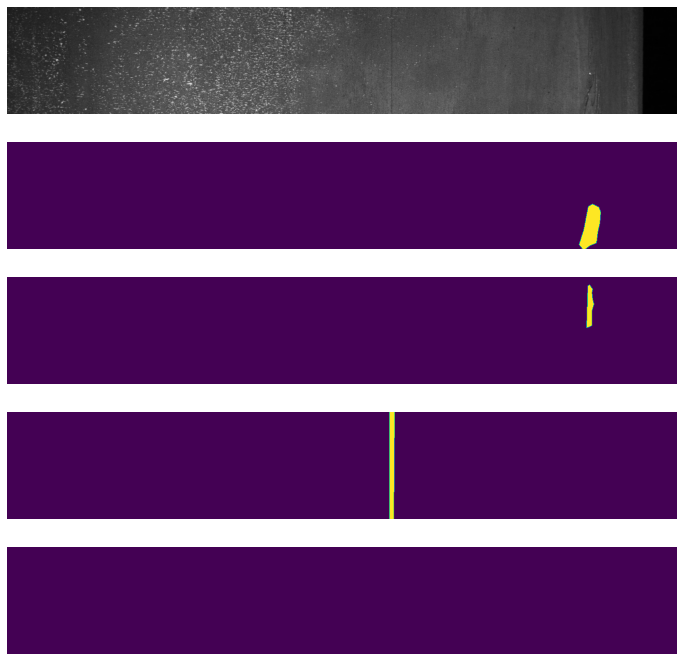

In [28]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"/content/drive/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

**Data Generator**

In [29]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/drive/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [30]:
BATCH_SIZE = 8

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [31]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

In [32]:
model = build_model((256, 1600, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1600,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 1600, 8  80          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 1600, 8  584         ['conv2d[0][0]']                 
                                )                                                             

In [34]:
checkpoint = ModelCheckpoint(
     'model.h5', 
      monitor='val_dice_coef', 
      verbose=0, 
      save_best_only=True, 
      save_weights_only=False,
      mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=30
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/30
1335/1335 [==============================] - 431s 323ms/step - loss: 0.9605 - dice_coef: 0.0931 - val_loss: 0.8440 - val_dice_coef: 0.2120
Epoch 2/30
1335/1335 [==============================] - 432s 324ms/step - loss: 0.7523 - dice_coef: 0.2997 - val_loss: 0.6857 - val_dice_coef: 0.3608
Epoch 3/30
1335/1335 [==============================] - 434s 325ms/step - loss: 0.6691 - dice_coef: 0.3782 - val_loss: 0.7282 - val_dice_coef: 0.3305
Epoch 4/30
1335/1335 [==============================] - 431s 323ms/step - loss: 0.6501 - dice_coef: 0.3962 - val_loss: 0.6396 - val_dice_coef: 0.4010
Epoch 5/30
1335/1335 [==============================] - 431s 323ms/step - loss: 0.6139 - dice_coef: 0.4303 - val_loss: 0.6042 - val_dice_coef: 0.4427
Epoch 6/30
1335/1335 [==============================] - 430s 322ms/step - loss: 0.5880 - dice_coef: 0.4556 - val_loss: 0.7419 - val_dice_coef: 0.3061
Epoch 7/30
1335/1335 [==============================] - 430s 322ms/step - loss: 0.5690 - dice_coef: 

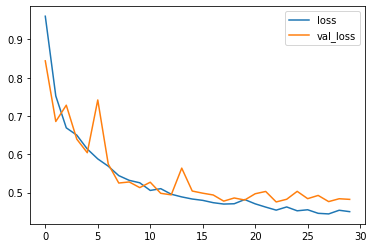

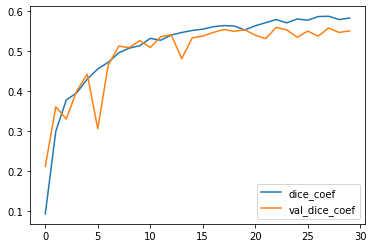

In [35]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [1]:
model.load_weights('model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path='/content/drive/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

NameError: ignored

In [ ]:
test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)